# Introdução

## Regra nº 1 do curso

Só podemos usar números **uniformes \(U(0,1)\)** como fonte de aleatoriedade.  
Tudo o mais — Normal, Exponencial, Poisson, etc. — deve ser gerado **a partir de \(U(0,1)\)** usando transformações como inversa, rejeição ou composição.


### Pergunta: Se sabemos a CDF de $X$, qual a distribuição de $F(X)$? E de $F^{-1}(U)$?


## Exemplo: Gerando uma variável Exponencial$(\lambda)$ a partir de $U(0,1)$

A CDF da Exponencial$(\lambda)$ é:
$$
F(x) = 1 - e^{-\lambda x}, \quad x \ge 0.
$$

Pela conclusão anterior, se $U \sim U(0,1)$ então $F^{-1}(U) \sim X$.  
Logo:
$$
u = F(x) \quad \Rightarrow \quad x = F^{-1}(u) = -\frac{1}{\lambda} \ln(1 - u).
$$

Portanto, para gerar $X \sim \text{Exponencial}(\lambda)$:
$$
X = -\frac{1}{\lambda} \ln(1 - U), \quad U \sim U(0,1).
$$

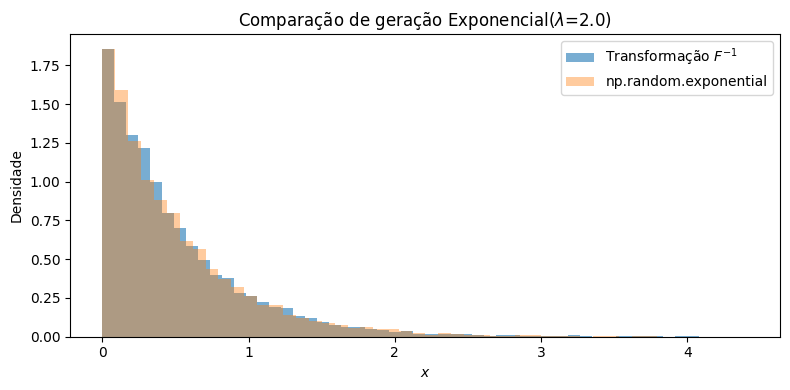

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# parâmetros
n = 10000
lmbda = 2.0

# --- Geração via transformação F^{-1} ---
U = np.random.rand(n)
X_manual = -np.log(1 - U) / lmbda

# --- Geração via NumPy ---
X_numpy = np.random.exponential(scale=1/lmbda, size=n)

# --- Plot ---
plt.figure(figsize=(8,4))

plt.hist(X_manual, bins=50, density=True, alpha=0.6, label='Transformação $F^{-1}$')
plt.hist(X_numpy, bins=50, density=True, alpha=0.4, label='np.random.exponential')

plt.xlabel('$x$')
plt.ylabel('Densidade')
plt.title(f'Comparação de geração Exponencial($\\lambda$={lmbda})')
plt.legend()
plt.tight_layout()
plt.show()


## Movimento Browniano 2D

O movimento browniano é um exemplo clássico de processo estocástico, no qual a
posição de uma partícula evolui ao longo do tempo com incrementos aleatórios
independentes, tipicamente distribuídos de forma normal. No exemplo abaixo,
utilizamos a função `np.random.normal` para gerar esses incrementos e simular a
trajetória em duas dimensões.

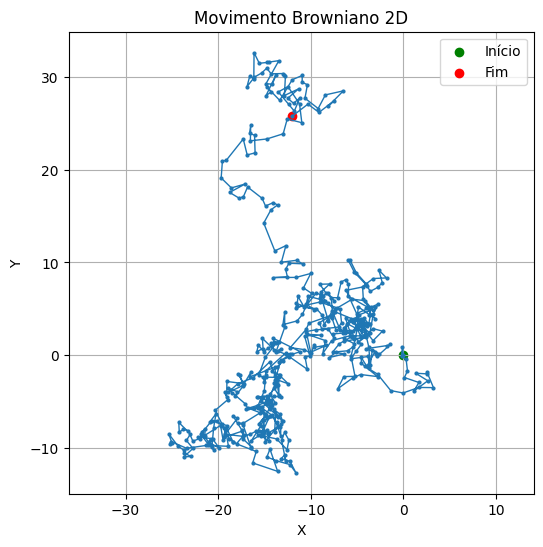

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# parâmetros
n_passos = 500
dt = 1.0
mu = 0.0
sigma = 1.0

# gerar incrementos normais independentes
inc_x = np.random.normal(mu, sigma*np.sqrt(dt), size=n_passos)
inc_y = np.random.normal(mu, sigma*np.sqrt(dt), size=n_passos)

# calcular posições cumulativas
x = np.cumsum(inc_x)
y = np.cumsum(inc_y)

# adicionar ponto inicial (0,0)
x = np.insert(x, 0, 0)
y = np.insert(y, 0, 0)

# plotar trajetória
plt.figure(figsize=(6,6))
plt.plot(x, y, marker='o', markersize=2, linewidth=1)
plt.scatter(0, 0, color='green', label='Início')
plt.scatter(x[-1], y[-1], color='red', label='Fim')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Movimento Browniano 2D')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


No entanto, vale lembrar que aqui estamos utilizando uma função pronta da
biblioteca NumPy que **fere a Regra nº 1 do curso** — a de que só podemos usar
números uniformes \(U(0,1)\) como fonte de aleatoriedade. Mais adiante no curso,
aprenderemos a implementar este mesmo processo **do zero**, gerando os
incrementos normais a partir de uniformes, e assim simulando o movimento
browniano sem quebrar nossa regra fundamental.


## Exemplo de Difusão em 2D

Um processo de difusão descreve como partículas se espalham ao longo do tempo
devido a movimentos aleatórios, podendo ser modelado por um movimento browniano
coletivo. Esse conceito é a base tanto de fenômenos físicos (como dispersão de
gases) quanto de técnicas modernas de aprendizado de máquinas, como os modelos
de difusão usados para gerar imagens e outros dados sintéticos.

No exemplo abaixo, simulamos várias partículas partindo de um mesmo ponto
inicial e observamos sua dispersão ao longo do tempo. Aqui, usamos `np.random.normal`
para gerar os incrementos — mas, conforme nossa **Regra nº 1**, aprenderemos a
fazer isso apenas com números uniformes \(U(0,1)\) ao longo do curso.


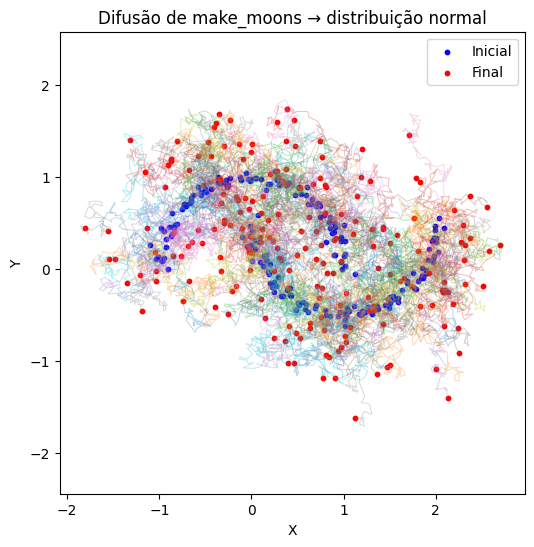

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# parâmetros
n_pontos = 200
n_passos = 100
sigma = 0.05  # intensidade do ruído por passo

# gerar dados iniciais
X, _ = make_moons(n_samples=n_pontos, noise=0.05)

# armazenar trajetórias para visualização
traj = np.zeros((n_passos+1, n_pontos, 2))
traj[0] = X

# simulação do processo de difusão
for t in range(1, n_passos+1):
    # drift em direção a uma normal centrada (aqui 0) é zero — só ruído
    noise = np.random.normal(0, sigma, size=(n_pontos, 2))
    traj[t] = traj[t-1] + noise

# plotar algumas trajetórias
plt.figure(figsize=(6,6))
for i in range(n_pontos):
    plt.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.3, linewidth=0.7)

plt.scatter(traj[0, :, 0], traj[0, :, 1], color='blue', s=10, label='Inicial')
plt.scatter(traj[-1, :, 0], traj[-1, :, 1], color='red', s=10, label='Final')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Difusão de make_moons → distribuição normal')
plt.axis('equal')
plt.legend()
plt.show()


Estimativa via Monte Carlo: 0.4712
Solução analítica:         0.5000
Erro absoluto:             0.0288


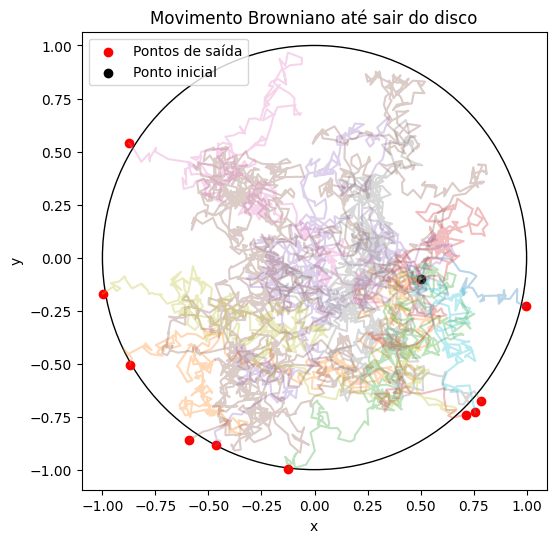

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Parâmetros do problema
# ------------------------
R = 1.0             # raio do disco
dt = 1e-3           # passo de tempo para simulação
n_traj = 1000       # número de trajetórias para estimativa
n_traj_show = 10    # número de trajetórias para exibir
x0 = np.array([0.5, -0.1])  # ponto inicial dentro do disco

# condição de contorno g no bordo do disco
def g_boundary(point):
    theta = np.arctan2(point[1], point[0])
    return np.cos(theta)  # solução harmônica conhecida

# solução analítica para este g
def u_analytical(point):
    r = np.sqrt(point[0]**2 + point[1]**2)
    theta = np.arctan2(point[1], point[0])
    return (r**1) * np.cos(theta)  # modo n=1

# ------------------------
# Função para simular uma trajetória até sair do disco
# ------------------------
def simulate_brownian_exit(x_start):
    pos = np.array(x_start)
    while np.linalg.norm(pos) < R:
        pos += np.sqrt(dt) * np.random.normal(size=2)
    return pos

# ------------------------
# Simulação para estimar u(x0)
# ------------------------
exit_values = []
exit_points_show = []
trajectories_show = []

for i in range(n_traj):
    pos = np.array(x0)
    traj = [pos.copy()]
    while np.linalg.norm(pos) < R:
        pos += np.sqrt(dt) * np.random.normal(size=2)
        if i < n_traj_show:
            traj.append(pos.copy())
    val = g_boundary(pos)
    exit_values.append(val)
    if i < n_traj_show:
        trajectories_show.append(np.array(traj))
        exit_points_show.append(pos)

u_estimate = np.mean(exit_values)
u_exact = u_analytical(x0)

print(f"Estimativa via Monte Carlo: {u_estimate:.4f}")
print(f"Solução analítica:         {u_exact:.4f}")
print(f"Erro absoluto:             {abs(u_estimate - u_exact):.4f}")

# ------------------------
# Visualização
# ------------------------
fig, ax = plt.subplots(figsize=(6,6))

# contorno do disco
circle = plt.Circle((0,0), R, color='black', fill=False)
ax.add_artist(circle)

# trajetórias simuladas
for traj in trajectories_show:
    ax.plot(traj[:,0], traj[:,1], alpha=0.3)

# pontos de saída
exit_points_show = np.array(exit_points_show)
ax.scatter(exit_points_show[:,0], exit_points_show[:,1],
           color='red', label='Pontos de saída')

# ponto inicial
ax.scatter([x0[0]], [x0[1]], color='black', label='Ponto inicial')

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Movimento Browniano até sair do disco')
ax.legend()
plt.show()
